In [10]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack, save_npz, load_npz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Cleaned Data

In [11]:
# Load cleaned data from Member 1
df = pd.read_csv('cleaned_data.csv')
print(f"Loaded data shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
df.head()

Loaded data shape: (400000, 5)

Columns: ['label', 'text', 'text_clean', 'length', 'tokens']

Class distribution:
label
2    200000
1    200000
Name: count, dtype: int64


,label,text,text_clean,length,tokens
0,2,Great CD: My lovely Pat has one of the GREAT v...,great cd my lovely pat has one of the great vo...,513,"['great', 'cd', 'my', 'lovely', 'pat', 'has', ..."
1,2,One of the best game music soundtracks - for a...,one of the best game music soundtracks for a g...,798,"['one', 'of', 'the', 'best', 'game', 'music', ..."
2,1,Batteries died within a year ...: I bought thi...,batteries died within a year i bought this cha...,323,"['batteries', 'died', 'within', 'a', 'year', '..."
3,2,"works fine, but Maha Energy is better: Check o...",works fine but maha energy is better check out...,221,"['works', 'fine', 'but', 'maha', 'energy', 'is..."
4,2,Great for the non-audiophile: Reviewed quite a...,great for the non audiophile reviewed quite a ...,403,"['great', 'for', 'the', 'non', 'audiophile', '..."


In [12]:
# Load train/validation splits
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')

print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"\nTrain class distribution:\n{train_df['label'].value_counts()}")
print(f"\nValidation class distribution:\n{val_df['label'].value_counts()}")

Train set: (320000, 5)
Validation set: (80000, 5)

Train class distribution:
label
2    160000
1    160000
Name: count, dtype: int64

Validation class distribution:
label
2    40000
1    40000
Name: count, dtype: int64


## 2. Lexical Feature Engineering
Create hand-crafted features from text

In [13]:
def extract_lexical_features(df, text_col='text_clean'):
    """
    Extract lexical/statistical features from text:
    - Character count
    - Word count
    - Average word length
    - Uppercase ratio (from original text if available)
    - Digit count
    - Exclamation count
    - Question mark count
    """
    features = pd.DataFrame()
    
    # Character count (already exists as 'length')
    features['char_count'] = df[text_col].fillna('').str.len()
    
    # Word count
    features['word_count'] = df[text_col].fillna('').str.split().str.len()
    
    # Average word length
    features['avg_word_length'] = features['char_count'] / (features['word_count'] + 1)
    
    # Uppercase ratio (from original text if available)
    if 'text' in df.columns:
        features['uppercase_ratio'] = df['text'].fillna('').apply(
            lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1)
        )
    
    # Digit count (from original text)
    if 'text' in df.columns:
        features['digit_count'] = df['text'].fillna('').str.count(r'\d')
    
    # Punctuation counts (from original text)
    if 'text' in df.columns:
        features['exclamation_count'] = df['text'].fillna('').str.count('!')
        features['question_count'] = df['text'].fillna('').str.count('\?')
        features['punctuation_count'] = df['text'].fillna('').str.count(r'[.,;:!?]')
    
    return features

# Extract lexical features
train_lexical = extract_lexical_features(train_df)
val_lexical = extract_lexical_features(val_df)

print("Lexical features extracted!")
print(f"Feature shape: {train_lexical.shape}")
print(f"\nFeature columns: {train_lexical.columns.tolist()}")
train_lexical.describe()

Lexical features extracted!
Feature shape: (320000, 8)

Feature columns: ['char_count', 'word_count', 'avg_word_length', 'uppercase_ratio', 'digit_count', 'exclamation_count', 'question_count', 'punctuation_count']


,char_count,word_count,avg_word_length,uppercase_ratio,digit_count,exclamation_count,question_count,punctuation_count
count,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000
mean,419.578091,79.463159,5.187876,0.041282,1.539087,0.882656,0.182863,10.670184
std,231.841669,43.486052,0.396964,0.073123,3.502277,2.548930,0.725099,6.669047
min,36.000000,6.000000,1.983051,0.000000,0.000000,0.000000,0.000000,1.000000
25%,224.000000,43.000000,4.924370,0.020457,0.000000,0.000000,0.000000,6.000000
50%,372.000000,71.000000,5.163934,0.028846,0.000000,0.000000,0.000000,9.000000
75%,579.000000,109.000000,5.425532,0.041667,2.000000,1.000000,0.000000,14.000000
max,1011.000000,236.000000,12.000000,0.870787,572.000000,219.000000,45.000000,258.000000


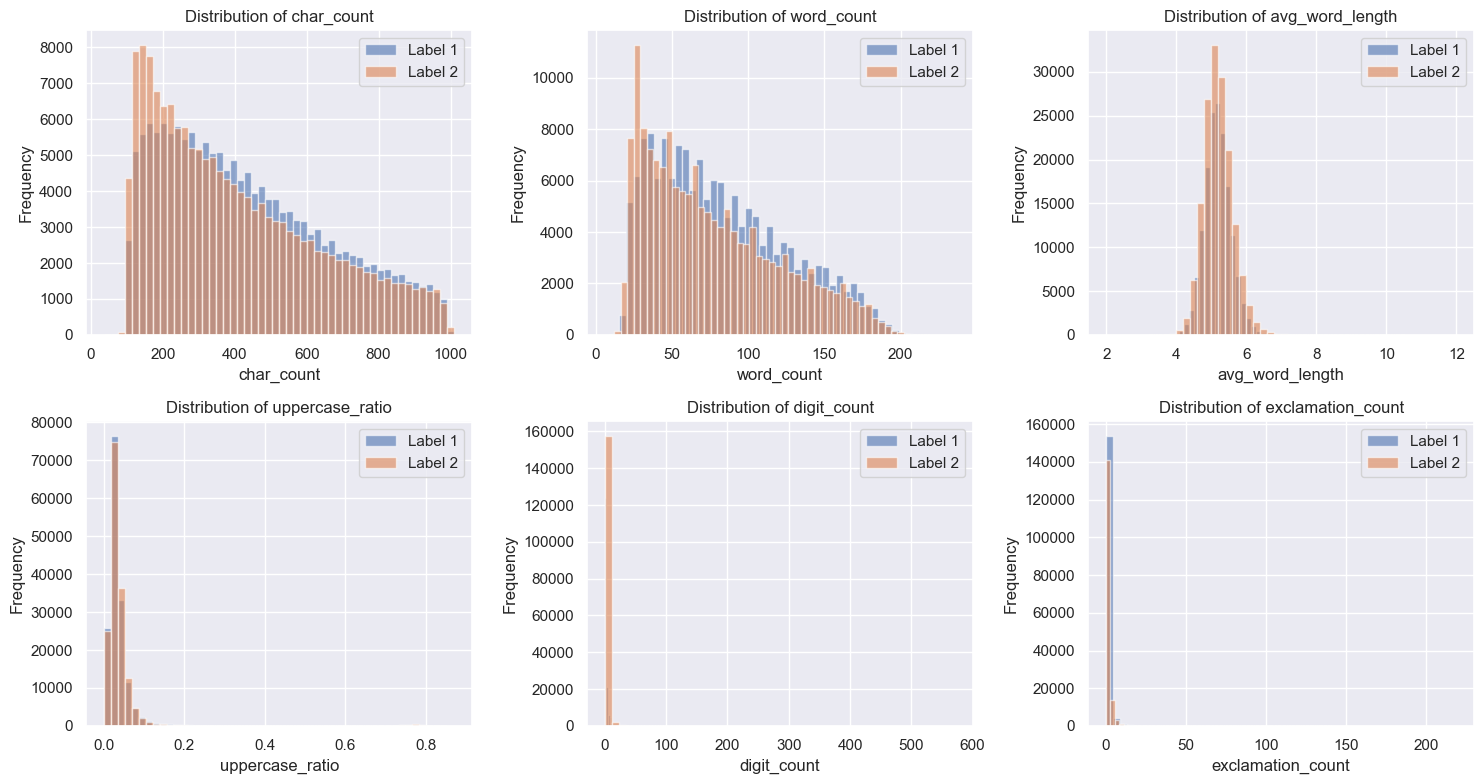


Lexical features by class:

Label 1:
char_count           434.333737
word_count            82.418550
avg_word_length        5.180583
uppercase_ratio        0.041182
digit_count            1.719069
exclamation_count      0.793613
question_count         0.264587
punctuation_count     11.136731
dtype: float64

Label 2:
char_count           404.822444
word_count            76.507769
avg_word_length        5.195169
uppercase_ratio        0.041383
digit_count            1.359106
exclamation_count      0.971700
question_count         0.101138
punctuation_count     10.203637
dtype: float64


In [14]:
# Visualize lexical features by class
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(train_lexical.columns[:6]):
    ax = axes[idx]
    for label in sorted(train_df['label'].unique()):
        data = train_lexical[train_df['label'] == label][col]
        ax.hist(data, bins=50, alpha=0.6, label=f'Label {label}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col}')
    ax.legend()
    
plt.tight_layout()
plt.show()

print("\nLexical features by class:")
for label in sorted(train_df['label'].unique()):
    print(f"\nLabel {label}:")
    print(train_lexical[train_df['label'] == label].mean())

## 3. TF-IDF Feature Engineering with Parameter Tuning
Experiment with different TF-IDF configurations

In [15]:
# Define TF-IDF configurations to test
tfidf_configs = [
    # Unigrams only
    {'name': 'tfidf_unigram_5k', 'max_features': 5000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95},
    {'name': 'tfidf_unigram_10k', 'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95},
    {'name': 'tfidf_unigram_20k', 'max_features': 20000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95},
    
    # Bigrams
    {'name': 'tfidf_bigram_10k', 'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95},
    {'name': 'tfidf_bigram_20k', 'max_features': 20000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95},
    
    # Trigrams
    {'name': 'tfidf_trigram_15k', 'max_features': 15000, 'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.95},
]

print(f"Will test {len(tfidf_configs)} TF-IDF configurations")
for config in tfidf_configs:
    print(f"  - {config['name']}: max_features={config['max_features']}, ngram_range={config['ngram_range']}")

Will test 6 TF-IDF configurations
  - tfidf_unigram_5k: max_features=5000, ngram_range=(1, 1)
  - tfidf_unigram_10k: max_features=10000, ngram_range=(1, 1)
  - tfidf_unigram_20k: max_features=20000, ngram_range=(1, 1)
  - tfidf_bigram_10k: max_features=10000, ngram_range=(1, 2)
  - tfidf_bigram_20k: max_features=20000, ngram_range=(1, 2)
  - tfidf_trigram_15k: max_features=15000, ngram_range=(1, 3)


In [16]:
# Create directory for feature matrices
feature_dir = Path('features')
feature_dir.mkdir(exist_ok=True)

# Store vectorizers and metadata
vectorizers = {}
feature_metadata = {}

# Fit and transform TF-IDF for each configuration
for config in tfidf_configs:
    name = config['name']
    print(f"\n{'='*60}")
    print(f"Processing: {name}")
    print(f"{'='*60}")
    
    # Create vectorizer
    vectorizer = TfidfVectorizer(
        max_features=config['max_features'],
        ngram_range=config['ngram_range'],
        min_df=config['min_df'],
        max_df=config['max_df'],
        sublinear_tf=True,  # Use log scaling
        strip_accents='unicode',
        analyzer='word',
        token_pattern=r'\w{2,}',  # Words with at least 2 characters
        stop_words='english'
    )
    
    # Fit on training data
    X_train_tfidf = vectorizer.fit_transform(train_df['text_clean'].fillna(''))
    X_val_tfidf = vectorizer.transform(val_df['text_clean'].fillna(''))
    
    print(f"Train shape: {X_train_tfidf.shape}")
    print(f"Val shape: {X_val_tfidf.shape}")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"Sparsity: {1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.4f}")
    
    # Save feature matrices
    save_npz(feature_dir / f'{name}_train.npz', X_train_tfidf)
    save_npz(feature_dir / f'{name}_val.npz', X_val_tfidf)
    
    # Save vectorizer
    with open(feature_dir / f'{name}_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    
    # Store metadata
    vectorizers[name] = vectorizer
    feature_metadata[name] = {
        'config': config,
        'train_shape': X_train_tfidf.shape,
        'val_shape': X_val_tfidf.shape,
        'vocab_size': len(vectorizer.vocabulary_),
        'feature_names': vectorizer.get_feature_names_out().tolist()
    }
    
    print(f"✓ Saved {name} features to {feature_dir}/")

print(f"\n{'='*60}")
print("All TF-IDF configurations processed!")
print(f"{'='*60}")


Processing: tfidf_unigram_5k
Train shape: (320000, 5000)
Val shape: (80000, 5000)
Vocabulary size: 5000
Sparsity: 0.9950
✓ Saved tfidf_unigram_5k features to features/

Processing: tfidf_unigram_10k
Train shape: (320000, 10000)
Val shape: (80000, 10000)
Vocabulary size: 10000
Sparsity: 0.9972
✓ Saved tfidf_unigram_10k features to features/

Processing: tfidf_unigram_20k
Train shape: (320000, 20000)
Val shape: (80000, 20000)
Vocabulary size: 20000
Sparsity: 0.9985
✓ Saved tfidf_unigram_20k features to features/

Processing: tfidf_bigram_10k
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\CSE437\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3701, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Admin.ARGHA\AppData\Local\Temp\ipykernel_37464\3547111272.py", line 30, in <module>
    X_train_tfidf = vectorizer.fit_transform(train_df['text_clean'].fillna(''))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\CSE437\.conda\Lib\site-packages\sklearn\feature_extraction\text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\CSE437\.conda\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\CSE437\.conda\Lib\site-packages\sklearn\feature_extraction\text.py", line 1386, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fi

## 4. Count-Based N-gram Features
Create count-based features (alternative to TF-IDF)

In [ ]:
# Count vectorizer configurations
count_configs = [
    {'name': 'count_unigram_10k', 'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95},
    {'name': 'count_bigram_10k', 'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95},
]

for config in count_configs:
    name = config['name']
    print(f"\nProcessing: {name}")
    
    # Create count vectorizer
    vectorizer = CountVectorizer(
        max_features=config['max_features'],
        ngram_range=config['ngram_range'],
        min_df=config['min_df'],
        max_df=config['max_df'],
        strip_accents='unicode',
        analyzer='word',
        token_pattern=r'\w{2,}',
        stop_words='english'
    )
    
    # Fit and transform
    X_train_count = vectorizer.fit_transform(train_df['text_clean'].fillna(''))
    X_val_count = vectorizer.transform(val_df['text_clean'].fillna(''))
    
    print(f"Train shape: {X_train_count.shape}")
    print(f"Val shape: {X_val_count.shape}")
    
    # Save
    save_npz(feature_dir / f'{name}_train.npz', X_train_count)
    save_npz(feature_dir / f'{name}_val.npz', X_val_count)
    
    with open(feature_dir / f'{name}_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    
    vectorizers[name] = vectorizer
    feature_metadata[name] = {
        'config': config,
        'train_shape': X_train_count.shape,
        'val_shape': X_val_count.shape,
        'vocab_size': len(vectorizer.vocabulary_)
    }
    
    print(f"✓ Saved {name} features")

print("\nCount-based features completed!")

## 6. Combined Feature Matrices
Create combined feature matrices (TF-IDF + Lexical + Sentiment)

In [ ]:
# Save lexical features
train_lexical.to_csv(feature_dir / 'train_lexical.csv', index=False)
val_lexical.to_csv(feature_dir / 'val_lexical.csv', index=False)

print("✓ Lexical features saved!")

# Convert lexical features to sparse format
from scipy.sparse import csr_matrix
train_lexical_sparse = csr_matrix(train_lexical.values)
val_lexical_sparse = csr_matrix(val_lexical.values)

print(f"\nLexical features (sparse) - Train: {train_lexical_sparse.shape}, Val: {val_lexical_sparse.shape}")

In [ ]:
# Create combined feature matrices for best TF-IDF configs
best_configs = ['tfidf_unigram_10k', 'tfidf_bigram_10k', 'tfidf_trigram_15k']

for config_name in best_configs:
    print(f"\nCreating combined features for: {config_name}")
    
    # Load TF-IDF features
    X_train_tfidf = load_npz(feature_dir / f'{config_name}_train.npz')
    X_val_tfidf = load_npz(feature_dir / f'{config_name}_val.npz')
    
    # Combine TF-IDF + Lexical
    X_train_combined = hstack([X_train_tfidf, train_lexical_sparse])
    X_val_combined = hstack([X_val_tfidf, val_lexical_sparse])
    
    print(f"  TF-IDF + Lexical - Train: {X_train_combined.shape}, Val: {X_val_combined.shape}")
    
    # Save combined features
    save_npz(feature_dir / f'{config_name}_combined_train.npz', X_train_combined)
    save_npz(feature_dir / f'{config_name}_combined_val.npz', X_val_combined)
    
    print(f"  ✓ Saved combined features for {config_name}")

print("\n" + "="*60)
print("All combined feature matrices created!")
print("="*60)

## 7. Save Labels and Metadata

In [ ]:
# Save labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values

np.save(feature_dir / 'train_labels.npy', train_labels)
np.save(feature_dir / 'val_labels.npy', val_labels)

print("✓ Labels saved!")
print(f"  Train labels: {train_labels.shape}")
print(f"  Val labels: {val_labels.shape}")

In [ ]:
# Save comprehensive metadata
metadata = {
    'dataset': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'num_classes': train_df['label'].nunique(),
        'class_distribution': train_df['label'].value_counts().to_dict()
    },
    'lexical_features': {
        'num_features': len(train_lexical.columns),
        'feature_names': train_lexical.columns.tolist()
    },
    'vectorizers': {}
}

# Add vectorizer metadata
for name, vec_metadata in feature_metadata.items():
    metadata['vectorizers'][name] = {
        'config': vec_metadata['config'],
        'train_shape': [int(x) for x in vec_metadata['train_shape']],
        'val_shape': [int(x) for x in vec_metadata['val_shape']],
        'vocab_size': int(vec_metadata['vocab_size'])
    }

# Save metadata as JSON
with open(feature_dir / 'feature_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved to feature_metadata.json")

## 8. Feature Engineering Summary Report

In [ ]:
print("="*80)
print("FEATURE ENGINEERING SUMMARY REPORT")
print("="*80)

print("\n1. DATASET INFO")
print("-" * 80)
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Number of classes: {train_df['label'].nunique()}")
print(f"Class distribution: {dict(train_df['label'].value_counts())}")

print("\n2. LEXICAL FEATURES")
print("-" * 80)
print(f"Number of lexical features: {len(train_lexical.columns)}")
print(f"Feature names: {', '.join(train_lexical.columns)}")

print("\n3. TF-IDF CONFIGURATIONS")
print("-" * 80)
for name, meta in feature_metadata.items():
    if name.startswith('tfidf'):
        config = meta['config']
        print(f"\n{name}:")
        print(f"  - Max features: {config['max_features']}")
        print(f"  - N-gram range: {config['ngram_range']}")
        print(f"  - Min DF: {config['min_df']}, Max DF: {config['max_df']}")
        print(f"  - Vocabulary size: {meta['vocab_size']:,}")
        print(f"  - Matrix shape (train): {meta['train_shape']}")

print("\n4. COUNT VECTORIZER CONFIGURATIONS")
print("-" * 80)
for name, meta in feature_metadata.items():
    if name.startswith('count'):
        config = meta['config']
        print(f"\n{name}:")
        print(f"  - Max features: {config['max_features']}")
        print(f"  - N-gram range: {config['ngram_range']}")
        print(f"  - Vocabulary size: {meta['vocab_size']:,}")
        print(f"  - Matrix shape (train): {meta['train_shape']}")

print("\n5. COMBINED FEATURE MATRICES")
print("-" * 80)
print("The following combined feature matrices are available:")
for config_name in best_configs:
    print(f"\n{config_name}:")
    print(f"  - {config_name}_train.npz (TF-IDF only)")
    print(f"  - {config_name}_combined_train.npz (TF-IDF + Lexical)")

print("\n6. FILES SAVED IN 'features/' DIRECTORY")
print("-" * 80)
feature_files = sorted(feature_dir.glob('*'))
print(f"Total files: {len(feature_files)}")
print("\nKey files:")
for f in feature_files[:20]:  # Show first 20 files
    print(f"  - {f.name}")
if len(feature_files) > 20:
    print(f"  ... and {len(feature_files) - 20} more files")

print("\n7. RECOMMENDATIONS FOR MODEL TRAINING")
print("-" * 80)
print("Start with these feature configurations:")
print("  1. tfidf_unigram_10k_train.npz (baseline)")
print("  2. tfidf_bigram_10k_combined_train.npz (TF-IDF + Lexical)")
print("  3. tfidf_trigram_15k_combined_train.npz (TF-IDF + Lexical)")
print("\nCompare results to find the best feature set!")

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE!")
print("="*80)

## 9. Quick Example: Load Features for Training

In [ ]:
# Example of how to load features for model training
print("Example: Loading features for model training\n")
print("="*60)

# Load a specific feature matrix
feature_name = 'tfidf_bigram_10k_combined'
X_train = load_npz(feature_dir / f'{feature_name}_train.npz')
X_val = load_npz(feature_dir / f'{feature_name}_val.npz')
y_train = np.load(feature_dir / 'train_labels.npy')
y_val = np.load(feature_dir / 'val_labels.npy')

print(f"Loaded features: {feature_name}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"\nSparsity: {1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1]):.4f}")

print("\n" + "="*60)
print("Ready to train models with these features!")
print("="*60)